Определение языка (language detection)
--------------------


In [129]:
import codecs
import collections
import sys
import json
import wikipedia
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from itertools import islice, tee
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

%matplotlib inline

### Первый метод: частотные слова

#### Скачаем немного википедии для тестов

In [1]:
def get_texts_for_lang(lang, n=10): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        except wikipedia.exceptions.WikipediaException:
            print('Skipping page {}'.format(page_name))
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

Сначала скачаем тексты, на которых будем обучаться.

In [2]:
wiki_texts = {}

for lang in ('kk', 'uk', 'be', 'fr'):
    wiki_texts[lang] = get_texts_for_lang(lang, 100)
    
    print(lang, len(wiki_texts[lang]))

kk 100


/home/anna/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /home/anna/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Skipping page Мозель
Skipping page Пеньяранда
Skipping page Бутівка
Skipping page 1222 (значення)
Skipping page Леончук
Skipping page Сундсвалль (значення)
Skipping page Крамськой
Skipping page Ґо
Skipping page Інтродукція (значення)
Skipping page Фульда (значення)
Skipping page Фей
Skipping page Марко Янкович
Skipping page Галтьє
uk 87
Skipping page Дунай (значэнні)
Skipping page Загорцы
Skipping page Любанскі бой
Skipping page Касцёл Святога Іосіфа
Skipping page Джэлам (значэнні)
Skipping page Свята-Параскева-Пятніцкая царква
Skipping page Зялёны Гай
be 93
Skipping page Ourlet
fr 99


Теперь - тексты, на которых будем тестировать.

In [ ]:
test_wiki_texts = {}

for lang in ('kk', 'uk', 'be', 'fr'):
    test_wiki_texts[lang] = get_texts_for_lang(lang, 100)
    
    print(lang, len(test_wiki_texts[lang]))

#### Считаем частотный список примерно так:

In [132]:
def tokenize(text):
    return text.split(' ')

def find_freqs(lang):
    freqs = collections.defaultdict(lambda: 0)
    probs = collections.defaultdict(lambda: 0)
    total_amount = 0

    corpus = wiki_texts[lang]
    
    for article in corpus:
        for word in tokenize(article.replace('\n', '').lower()):
            freqs[word] += 1
            total_amount += 1
    
    for key, value in freqs.items():
        probs[key] = log(value / total_amount)
    
    return probs

Напишем функцию для удаления повторяющихся слов.

In [133]:
kk_probs = find_freqs('kk')
uk_probs = find_freqs('uk')
be_probs = find_freqs('be')
fr_probs = find_freqs('fr')

def remove_duplicates(kk_probs, uk_probs, be_probs, fr_probs):
    all_probs = [kk_probs, uk_probs, be_probs, fr_probs]

    for i in range(len(all_probs)):
        for j in range(i + 1, len(all_probs)):
            a = set(all_probs[i].keys())
            b = set(all_probs[j].keys())

            intersection = a & b

            for key in intersection:
                del all_probs[i][key]
                del all_probs[j][key]

    langs = {'kk': kk_probs, 'uk': uk_probs, 'be': be_probs, 'fr': fr_probs}
    
    return langs

In [134]:
count_langs = remove_duplicates(kk_probs, uk_probs, be_probs, fr_probs)

Сохраним "тренировочный" словарь:

In [135]:
json.dump(count_langs, open('count_method.json', 'w', encoding='utf-8'))

In [94]:
def сounting_detection(text, langs):
    tokens = tokenize(text)
    counters = {}
    
    for lang, probs in langs.items():
        i = 0
        
        for token in tokens:
            if token in probs.keys():
                i +=1
        
        counters[lang] = i
    
    counters = sorted(counters, key=lambda n: counters[n], reverse=True)

    return counters[0]

In [99]:
def estimate_quality(func, test_wiki_texts):  
    test_labels = []
    pred_labels = []

    for lang, texts in test_wiki_texts.items():
        test_labels += [lang] * len(texts)
        #print(test_labels) 

        for text in texts:
            prediction = func(text, langs)
            pred_labels.append(prediction)   

    print(classification_report(test_labels, pred_labels))
    print("Макросредняя F1 мера - ", f1_score(test_labels, pred_labels, average="macro"))
    print("Микросредняя F1 мера - ", f1_score(test_labels, pred_labels, average="micro"))

    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(data=confusion_matrix(test_labels, pred_labels), annot=True, 
                fmt="d", xticklabels=langs.keys(), yticklabels=langs.keys(), ax=ax)
    plt.title("Confusion matrix")
    plt.show()

             precision    recall  f1-score   support

         be       1.00      0.99      0.99        94
         fr       0.99      1.00      0.99        92
         kk       1.00      1.00      1.00       100
         uk       1.00      1.00      1.00        96

avg / total       1.00      1.00      1.00       382

Макросредняя F1 мера -  0.997311750253
Микросредняя F1 мера -  0.997382198953


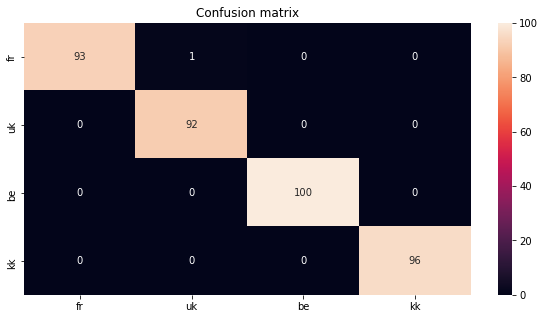

In [101]:
estimate_quality(сounting_detection, test_wiki_texts)

Как видно, качество распознавания на тестовых данных у этого метода почти равно 100%.

### Второй метод: частотные символьные n-граммы

Создадим функцию, которая преобразовывает строку в массив n-грамм заданной длины.

In [136]:
def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

Теперь создадим частотные словари n-грамм аналогично первому методу.

In [137]:
def find_ngrams(lang):
    freqs = collections.defaultdict(lambda: 0)
    
    corpus = wiki_texts[lang]
    
    for article in corpus:
        for ngram in make_ngrams(article.replace('\n', '').lower()):
            freqs[ngram] += 1

    return freqs

Удалим дубликаты.

In [138]:
kk_ngrams = find_ngrams('kk')
uk_ngrams = find_ngrams('uk')
be_ngrams = find_ngrams('be')
fr_ngrams = find_ngrams('fr')

ngrams_langs = remove_duplicates(kk_ngrams, uk_ngrams, be_ngrams, fr_ngrams)

Сохраним тренировочный словарь:

In [139]:
json.dump(ngrams_langs, open('ngrams_method.json', 'w', encoding='utf-8'))

In [123]:
def ngrams_detection(text, langs):
    ngrams = make_ngrams(text)
    counters = {}
    
    for lang, probs in langs.items():
        i = 0
        
        for ng in ngrams:
            if ng in probs.keys():
                i +=1
        
        counters[lang] = i
    
    counters = sorted(counters, key=lambda n: counters[n], reverse=True)

    return counters[0]

/home/anna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         be       0.33      1.00      0.49        94
         fr       0.99      1.00      0.99        92
         kk       1.00      0.01      0.02       100
         uk       0.00      0.00      0.00        96

avg / total       0.58      0.49      0.37       382

Макросредняя F1 мера -  0.376635792913
Микросредняя F1 мера -  0.489528795812


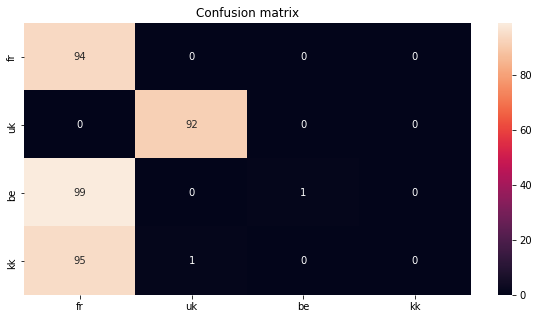

In [124]:
estimate_quality(ngrams_detection, test_wiki_texts)

Интересно, но этот метод дает гораздо худшие результаты. Как показала проверка, этому методу противопоказано удаление дубликатов: без него он дает точность в 100% на тестовой выборке.